In [1]:
import sympy
import numpy as np
import scipy.optimize
import networkx as nx
from math import comb
import IPython.display as disp
from scipy.optimize import fsolve
from matplotlib import pyplot as plt

In [2]:
nk,alpha,p=sympy.Symbol("n_c"),sympy.Symbol(r"\alpha"),sympy.Symbol("p")


def pk(k,quarantines):
    """Probability of infection after k trials given the node is not infected before.
    """
    if quarantines:
        return p*(1-alpha)**k #quarantines
    else:
        return 1-(1-p)*(1-alpha)**(k-1) #the original complex contagion
    

def pkn(k,n,quarantines): # does this work for quarantines? we don't need to forget the quarantine outcome here
    """Same as pk, but when there are n infected neighbors simultaneously trying to infect.
    """
    if quarantines:
        prob=0
        for act in range(n):
            prob=prob+(alpha-1)**(act)*(pk(k+1,quarantines)-1)**(act)*pk(k+1,quarantines)
        return prob
    else:
        prob=1
        for act in range(n):
            prob=prob*(1-pk(k+1+act,quarantines))
        return 1-prob

def process_motif(node,graph,processed,notprocessed,quarantines,singleinftrial=True):
    nsus,ninf,nrec = node
    n=nsus+ninf+nrec
    if ninf>0:
        exp=0
        #Infect others in this clique
        for newinf in range(1,nsus+1):
            #Create the new node
            newnode=(nsus-newinf,newinf,nrec+ninf)
            if newnode not in processed:
                notprocessed.add(newnode)
            
            #Link from this node to the new node 
            if singleinftrial:
                prob=comb(nsus,newinf)*(pk(nrec,quarantines)**newinf)*((1-pk(nrec,quarantines))**(nsus-newinf))
            else:
                prob=comb(nsus,newinf)*(pkn(nrec,ninf,quarantines)**newinf)*((1-pkn(nrec,ninf,quarantines))**(nsus-newinf))
            #prob=comb(nsus,newinf)*(pk(nrec,quarantines)**newinf)*((1-pk(nrec,quarantines))**(nsus-newinf))
            graph.add_edge(node,newnode,weight=prob)
            exp=exp+newinf*prob
        
        #Infect new cliques
        if nsus>0:
            graph.add_edge(node,(n-1,1,0),weight=(nk-1)*exp)
            #graph.add_edge(node,(n-1,1,0),weight=nsus*(nk-1)*pkn(nrec,ninf,quarantines))
            
def pkn_persistent(n):
    """Same as pk, but when there are n infected neighbors simultaneously trying to infect.
    Note that this doesn't depend on k.
    """ 
    prob=0
    for act in range(n):
        prob=prob+(alpha-1)**(act)*(p-1)**(act)*p
    return prob


def process_motif_persistent(node,graph,processed,notprocessed,quarantines,singleinftrial=True):
    nsus,ninf,nrec = node
    n=nsus+ninf+nrec
    if ninf>0:
        exp=0 #expected number of infected nodes
        #Infect others in this clique
        for newinf in range(1,nsus+1): #number of newly infected
            for newrec in range(0,nsus+1-newinf): #number of newly quarantined
                #Create the new node
                newnode=(nsus-newinf-newrec,newinf,nrec+ninf+newrec)
                assert sum(newnode)==sum(node),(node,newnode)
                if newnode not in processed:
                    notprocessed.add(newnode)

                #Link from this node to the new node    
                if singleinftrial:
                    prob=comb(nsus,newinf)*comb(nsus-newinf,newrec)*p**newinf*(1-p)**(nsus-newinf-newrec)*alpha**newrec*(1-alpha)**(nsus-newrec)
                else:
                    prob=comb(nsus,newinf)*comb(nsus-newinf,newrec)*pkn_persistent(ninf)**newinf*(1-pkn_persistent(ninf))**(nsus-newinf-newrec)*alpha**newrec*(1-alpha)**(nsus-newrec)
                graph.add_edge(node,newnode,weight=prob)
                exp=exp+newinf*prob
            
        
        #Infect new cliques
        if nsus>0:
            graph.add_edge(node,(n-1,1,0),weight=(nk-1)*exp)
                  
def motif_graph(motifsize,quarantines=False,persistent=False,singleinftrial=True):
    """Creates a motif graph where nodes are motifs and links are weighted with probabilities of producing
    new motifs in one time step.
    
    Nodes are tuples with three items with following convention:
    (number of susceptible nodes, number of infected nodes, number of recovered nodes)
    
    Parameters
    ----------
    motifsize : The number of nodes in the motif
    quarantines : If 
    """
    if persistent:
        assert quarantines, "Persistent only works with quarantines."
    graph=nx.DiGraph()
    notprocessed=set([(motifsize-1,1,0)])
    processed=set()
    while len(notprocessed)>0:
        node = notprocessed.pop()
        processed.add(node)
        if persistent:
            process_motif_persistent(node,graph,processed,notprocessed,quarantines,singleinftrial)
        else:
            process_motif(node,graph,processed,notprocessed,quarantines,singleinftrial)
    return graph

def canonical_node_order(graph):
    nodes=sorted(graph.nodes(),key=lambda x:list(reversed(x))) #canonical order for nodes
    return nodes

def canonical_node_map(graph):
    nodes=canonical_node_order(graph)
    nodeid=dict(((node,i+1) for i,node in enumerate(nodes)))
    return nodeid

def ratio(vector):
    v = vector[~np.isnan(vector)]
    return np.max(v)/np.min(v)

    
def print_motifs(g):
    nodes=canonical_node_order(g)
    print(r"$i$ & $S$ & $I$ & $R$ \\")
    print(r"\hline")
    for i in range(len(nodes)):
        node=nodes[i]
        print("$",i+1,"$&$", node[0],"$&$", node[1],"$&$", node[2],r"$\\")

def get_M_matrix(graph,verbose=False):
    nodes=canonical_node_order(graph)
    nodeid=canonical_node_map(graph)
    M=sympy.matrices.zeros(len(nodes),len(nodes))
    if verbose: print(r"$(i,j)$ & $m_{ij}$ \\")
    for node in nodes:
        for neigh in sorted(graph.predecessors(node),key=lambda x:nodeid[x]):
            if verbose: print("$(",nodeid[node],",",nodeid[neigh],")$&",end="")
            if verbose: print("$",sympy.latex(sympy.simplify(graph[neigh][node]['weight'])),r"$\\")
            
            M[nodeid[node]-1,nodeid[neigh]-1]=graph[neigh][node]['weight']
    return M

def numeric_find_alpha(M,nkval,pval):
    Mn=M.subs(nk,nkval).subs(p,pval)
    n=len(M[0,:])
    try:
        alphaval=scipy.optimize.bisect(lambda x:sympy.det(Mn.subs(alpha,x)- sympy.eye(n)),0,1,xtol=0.0001)
        return alphaval
    except ValueError:
        return np.NaN

def numeric_find_alpha_fast(M,nkval,pval):
    Mn=M.subs(nk,nkval).subs(p,pval)
    n=len(M[0,:])
    def myFunc(x):
        try:
            print('hooy')
            zena = np.linalg.eigvals(np.array(Mn.subs(alpha,x), dtype=float))[0] - 1
            print(x, zena)
            #np.array(sympy.det(Mn.subs(alpha,x)- sympy.eye(n)), dtype = float)
            return zena
        except:
            print('H')
            return 1
    try:
        alphaval=scipy.optimize.newton(myFunc, x0 = .5 + .01*np.random.random(), tol=1e-12, maxiter = 100)
        return alphaval
    except ValueError:
        return np.NaN

largest_eigen_value = lambda M, A, P, n_c: np.max(np.linalg.eigvals(np.array(M.subs(nk,n_c).subs(alpha,A).subs(p, P), dtype=float)))

# $\textbf{M}$ Matrix for 3-clique

In [3]:
g=motif_graph(3,quarantines=True,persistent=True,singleinftrial=False)
print_motifs(g)
print()
M=get_M_matrix(g,verbose=True)
print()

#for critical solving alpha/p given p/alpha:
d=sympy.det(M - sympy.eye(len(g)))
print(sympy.latex(sympy.simplify(d)))

$i$ & $S$ & $I$ & $R$ \\
\hline
$ 1 $&$ 2 $&$ 1 $&$ 0 $\\
$ 2 $&$ 1 $&$ 1 $&$ 1 $\\
$ 3 $&$ 0 $&$ 2 $&$ 1 $\\
$ 4 $&$ 0 $&$ 1 $&$ 2 $\\

$(i,j)$ & $m_{ij}$ \\
$( 1 , 1 )$&$ 2 p \left(- \alpha n_{c} + \alpha + n_{c} - 1\right) $\\
$( 1 , 2 )$&$ - p \left(\alpha - 1\right) \left(n_{c} - 1\right) $\\
$( 2 , 1 )$&$ - 2 p \left(\alpha - 1\right)^{2} \left(p - 1\right) $\\
$( 3 , 1 )$&$ p^{2} \left(\alpha - 1\right)^{2} $\\
$( 4 , 1 )$&$ 2 \alpha p \left(1 - \alpha\right) $\\
$( 4 , 2 )$&$ p \left(1 - \alpha\right) $\\

- 2 \alpha^{3} n_{c} p^{3} + 2 \alpha^{3} n_{c} p^{2} + 2 \alpha^{3} p^{3} - 2 \alpha^{3} p^{2} + 6 \alpha^{2} n_{c} p^{3} - 6 \alpha^{2} n_{c} p^{2} - 6 \alpha^{2} p^{3} + 6 \alpha^{2} p^{2} - 6 \alpha n_{c} p^{3} + 6 \alpha n_{c} p^{2} + 2 \alpha n_{c} p + 6 \alpha p^{3} - 6 \alpha p^{2} - 2 \alpha p + 2 n_{c} p^{3} - 2 n_{c} p^{2} - 2 n_{c} p - 2 p^{3} + 2 p^{2} + 2 p + 1


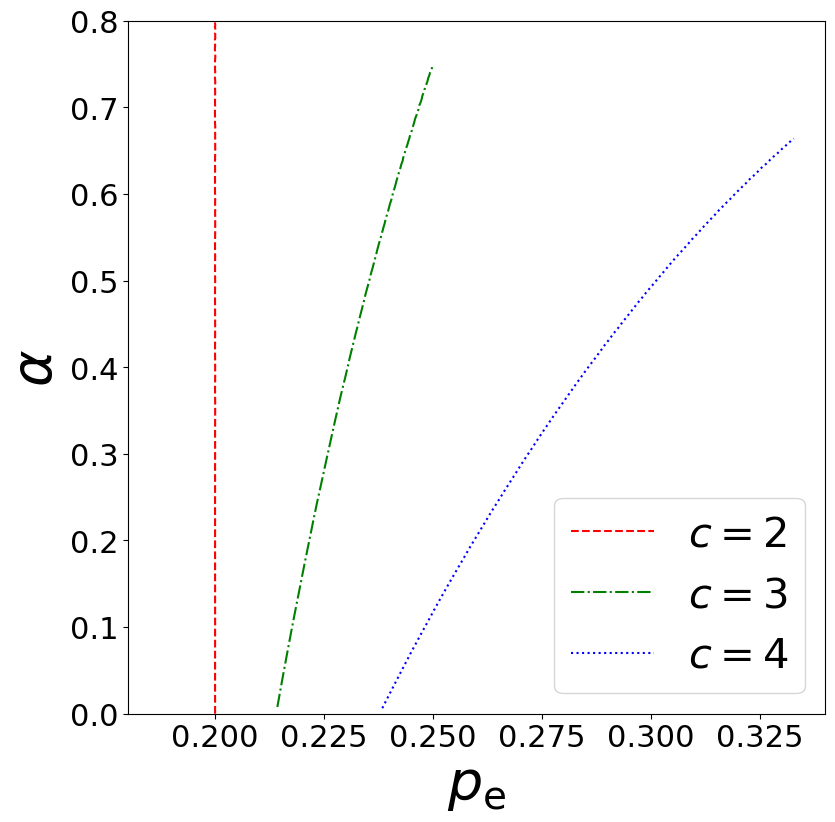

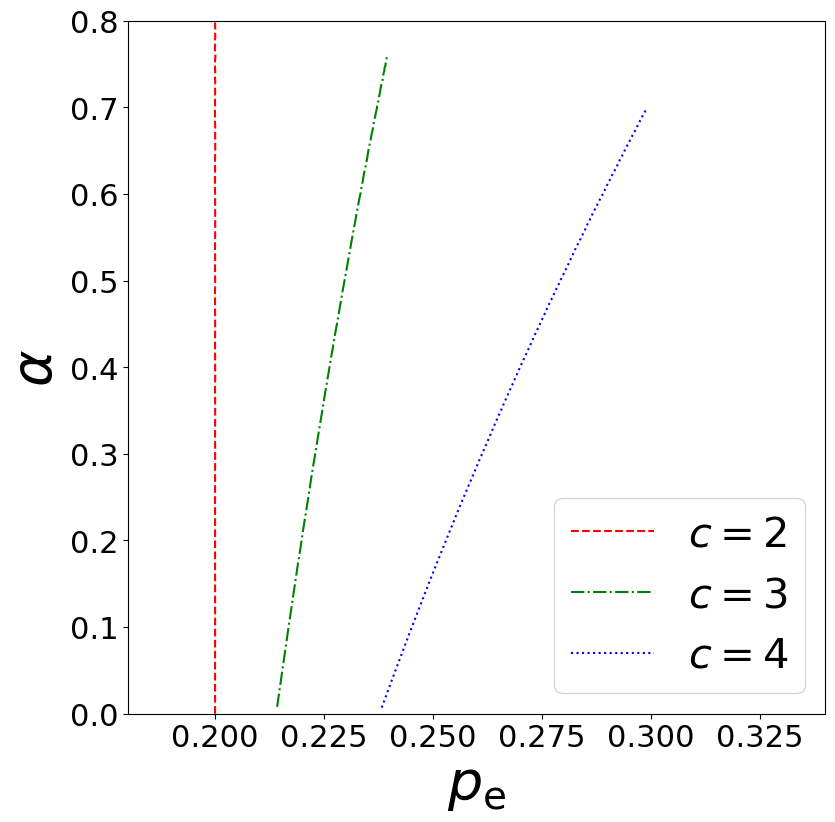

In [4]:
fig, axs = plt.subplots(figsize=(9,9))

k_nk_vals,ps,quarantines = [(2,6),(3,3),(4,2)],np.linspace(0.2,0.99,100),True
xmin=None
xmax=None
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
_i = 0

approx_data = []
for kval,nkval in k_nk_vals:
    g = motif_graph(kval,quarantines=True,persistent=True,singleinftrial=False)
    M = get_M_matrix(g)
    approx_data = np.load("approx_data.npy")
    alphas = approx_data[_i]
    #alphas = [numeric_find_alpha(M,nkval,pval) for pval in ps]
    #approx_data.append(alphas)
    axs.plot(ps*(1-np.array(alphas)) ,alphas,label=r"$c="+str(kval)+"$", color = cr[_i],linestyle=lins[_i], ms = 100)
    _i += 1
#np.save("approx_data", approx_data)
if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
axs.set_xlim([.18, .34])
axs.set_ylim([0, .8])
axs.set_xlabel(r'$p_{\mathrm{e}}$' , fontsize = 40)
axs.set_ylabel(r'$\alpha$' , fontsize = 40)
axs.tick_params(axis='y', labelsize= 22)
axs.tick_params(axis='x', labelsize= 22)
axs.legend(loc = 4, fontsize = 30)
#plt.savefig('mfield2-rescx.pdf')

_i = 0
fig, axs = plt.subplots(figsize=(9,9))
approx_data2 = []
for kval,nkval in k_nk_vals:
    g = motif_graph(kval,quarantines=True,persistent=False,singleinftrial=False)
    M = get_M_matrix(g)
    #alphas = [numeric_find_alpha(M,nkval,pval) for pval in ps]
    #approx_data2.append(alphas)
    approx_data2 = np.load("approx_data2.npy")
    alphas = approx_data2[_i]
    axs.plot(ps*(1-np.array(alphas)) ,alphas,label=r"$c="+str(kval)+"$", color = cr[_i],linestyle=lins[_i], ms = 100)
    _i += 1

#np.save("approx_data2", approx_data2)

if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
axs.set_xlim([.18, .34])
axs.set_ylim([0, .8])
axs.set_xlabel(r'$p_{\mathrm{e}}$' , fontsize = 40)
axs.set_ylabel(r'$\alpha$' , fontsize = 40)
axs.tick_params(axis='y', labelsize= 22)
axs.tick_params(axis='x', labelsize= 22)
axs.legend(loc = 4, fontsize = 30)

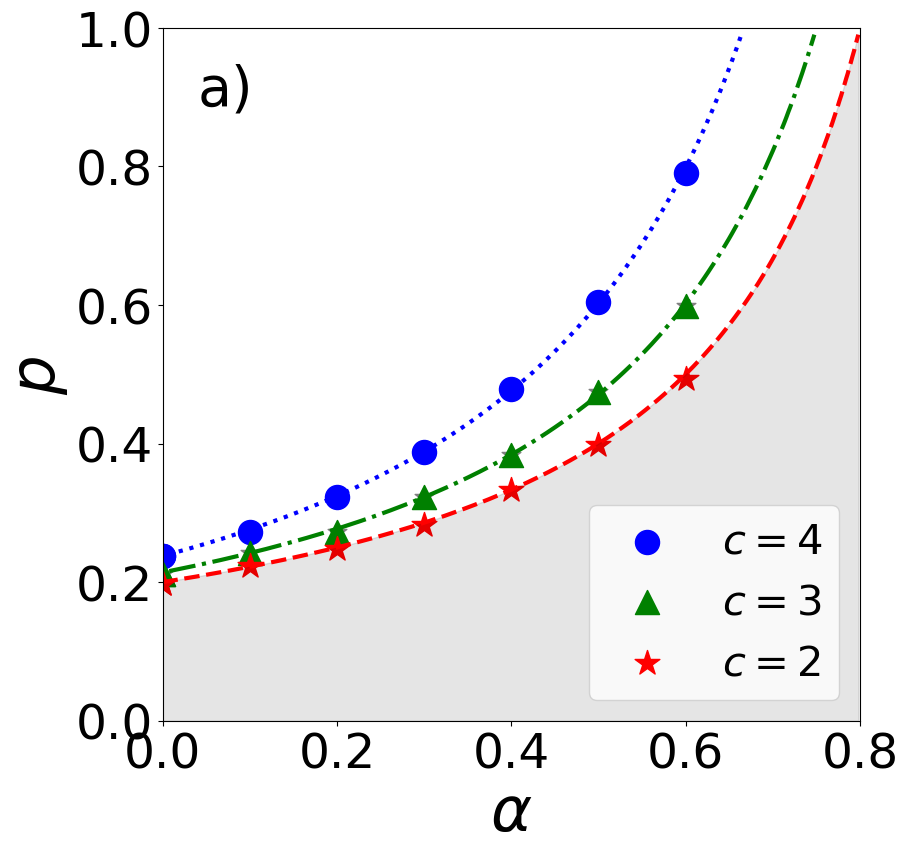

In [5]:
fig, axs = plt.subplots(figsize=(9,9))

k_nk_vals,ps,quarantines = [(2,6),(3,3),(4,2)],np.linspace(0.2,0.99,100),True
xmin=None
xmax=None
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
markers = [ '*',  '^', 'o']
_i = 0

for kval,nkval in k_nk_vals[::-1]:
    alphas2 = approx_data[_i]
    alphas = approx_data2[_i]
    #axs.plot(alphas,ps , color = cr[_i],linestyle=lins[_i])
    axs.plot(alphas2, ps ,color = cr[_i], linestyle = lins[_i],  linewidth=3)
    _i += 1

PA = np.load('PA.npy')
ALPHAS = np.load('ALPHAS.npy')

for _j in range(len(PA)):
    axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
    axs.scatter(ALPHAS[_j][2],PA[_j][2],  marker = 'o', s = 300, color = cr[2])
    axs.scatter(ALPHAS[_j][1],PA[_j][1],  marker = '^', s = 300, color = cr[1])
    axs.scatter(ALPHAS[_j][0],PA[_j][0],  marker = '*', s = 350, color =cr[0])
    
    if  _j == 0:
        axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
        axs.scatter(ALPHAS[_j][2],PA[_j][2],  marker = 'o', s = 300, color = cr[2], label=r"$c="+str(4)+"$")
        axs.scatter(ALPHAS[_j][1],PA[_j][1],  marker = '^', s = 300, color = cr[1], label=r"$c="+str(3)+"$" )
        axs.scatter(ALPHAS[_j][0],PA[_j][0],  marker = '*', s = 350, color =cr[0], label=r"$c="+str(2)+"$")
        

    _i += 1
#np.save("approx_data", approx_data)
if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
axs.set_xlim([0, .8])
axs.set_ylim([0, 1])
axs.set_ylabel(r'$p$' , fontsize = 45)
axs.set_xlabel(r'$\alpha$' , fontsize = 45)
axs.tick_params(axis='y', labelsize= 35)
axs.tick_params(axis='x', labelsize= 35)
axs.legend(loc = 4, fontsize = 30)
axs.text(0.05, 0.95, 'a)', transform=axs.transAxes, fontsize=40,va='top')
axs.fill_between(approx_data[0], ps, 0, color='black', alpha=.1)
plt.savefig('6a'+'.pdf',bbox_inches='tight')

0.9997283935546875
1.1469668544936926
1.376019935598499


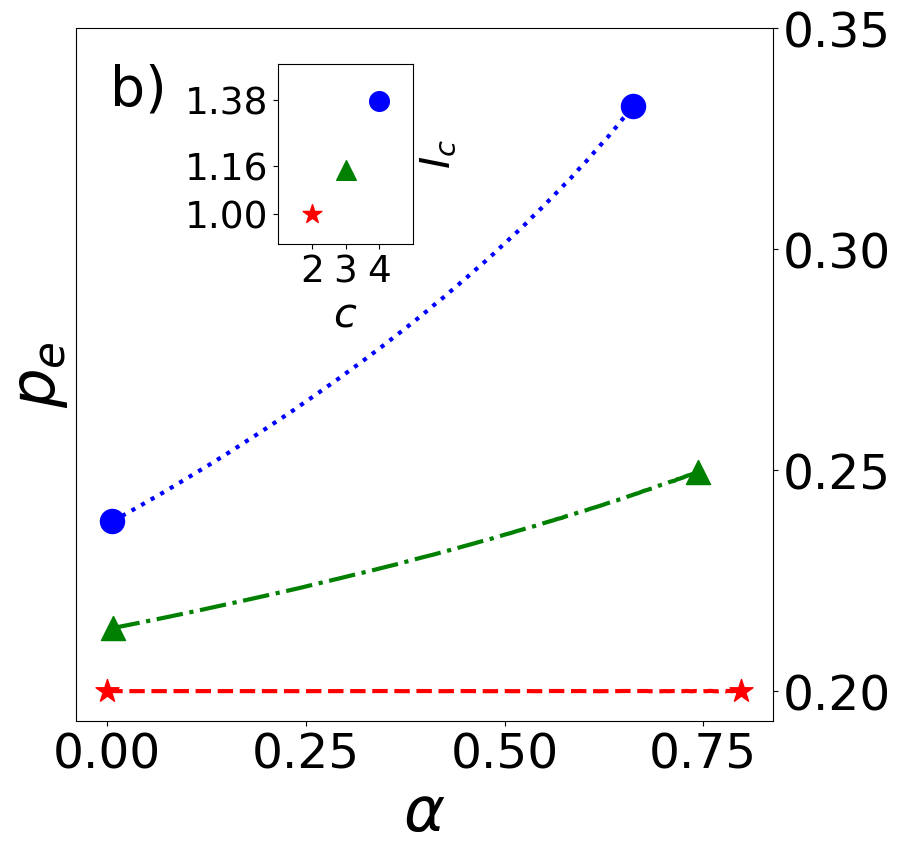

In [62]:
fig, axs = plt.subplots(figsize=(9,9))
left, bottom, width, height = [0.35, 0.64, 0.15, 0.2]

ax2 = fig.add_axes([left, bottom, width, height])
critsP = []
for _i in [0,1,2]:
    alphas = approx_data[_i]
    axs.plot(alphas,1*ps*(1-np.array(alphas)), label=r"$c="+str(kval)+"$", color = cr[_i],linestyle=lins[_i],  linewidth=3)
    left, bottom, width, height = [0.25, 0.64, 0.15, 0.2]
    if _i == 0:
        axs.scatter(alphas[-1], 1*ps[-1]*(1-np.array(alphas[-1])), color = cr[_i], s = 300, marker = '*')
        axs.scatter(alphas[0], 1*ps[0]*(1-np.array(alphas[0])), color = cr[_i], s = 300, marker = '*')
        xxx = ps[-1]*(1-np.array(alphas[-1]))/ps[0]*(1-np.array(alphas[0]))
        print(xxx)
        critsP.append(xxx)
    elif _i == 1:
        axs.scatter(alphas[-3], 1*ps[-3]*(1-np.array(alphas[-3])), color = cr[_i], s = 300, marker = '^')
        axs.scatter(alphas[2], 1*ps[2]*(1-np.array(alphas[2])), color = cr[_i], s = 300, marker = '^')
        xxx = ps[-3]*(1-np.array(alphas[-3]))/ps[2]*(1-np.array(alphas[2]))
        print(xxx)
        critsP.append(xxx)
    else:
        axs.scatter(alphas[-2], 1*ps[-2]*(1-np.array(alphas[-2])), color = cr[_i], s = 300, marker = 'o')
        axs.scatter(alphas[5], 1*ps[5]*(1-np.array(alphas[5])), color = cr[_i], s = 300, marker = 'o')
        xxx = ps[-2]*(1-np.array(alphas[-2]))/ps[5]*(1-np.array(alphas[5]))
        print(xxx)
        critsP.append(xxx)
ax2.scatter(2, critsP[0], marker = '*', s = 200, color = cr[0])
ax2.scatter(3, critsP[1], marker = '^', s = 200, color = cr[1])
ax2.scatter(4, critsP[2], marker = 'o', s = 200, color = cr[2])

ax2.set_xlim(1, 5)
ax2.set_ylim(.9, 1.5)
ax2.set_xticks([2, 3, 4])
ax2.set_yticks([1., 1.16, 1.38])
ax2.set_ylabel(r'$I_c$' , fontsize = 30)
ax2.set_xlabel(r'$c$' , fontsize = 30)
ax2.tick_params(axis='y', labelsize= 27)
ax2.yaxis.set_label_position("right")
#ax2.yaxis.tick_right()
ax2.tick_params(axis='x', labelsize= 27)

#axs.set_ylabel(r'$p_{\mathrm{e}}$' , fontsize = 40)
axs.set_xlabel(r'$\alpha$' , fontsize = 45)
axs.tick_params(axis='y', labelsize= 35)
axs.tick_params(axis='x', labelsize= 35)
axs.set_yticks([.2, .25, .3, .35])
#axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_ylabel(r'$p_e$' , fontsize = 45)

axs.text(0.05, 0.95, 'b)', transform=axs.transAxes, fontsize=40,va='top')

plt.savefig('6b.pdf', bbox_inches='tight')

0.8264460213913319
0.9277729845473193
1.053004644548583
1.2105875835408249
1.4449519581686978


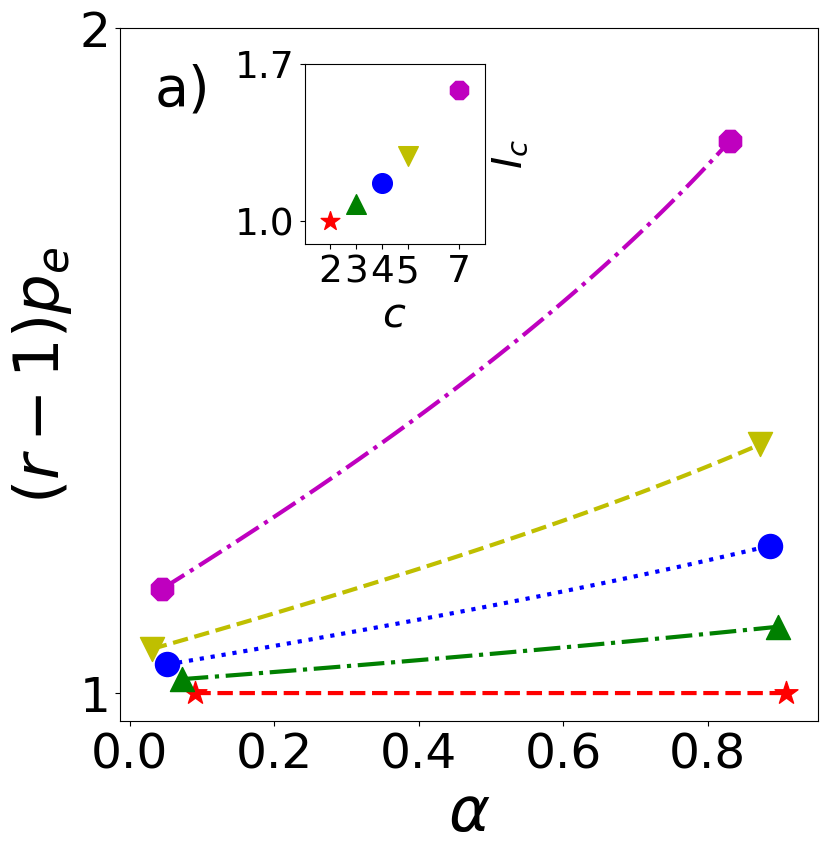

In [65]:
Aalphas = np.load('alphas_for_12.npy')

markers = ['*', '^', 'o',"v", "8", "s", "p"]
cr = ['r', 'g', 'b', 'y', 'm', 'c']
lins = ['dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted']
left, bottom, width, height = [0.33, 0.64, 0.2, 0.2]
fig, axs = plt.subplots(figsize=(9,9))
ax2 = fig.add_axes([left, bottom, width, height])

ps = np.linspace(0.0,0.99,100)
critsP = []
for _i in [0,1,2,3,4]:
    alphas = np.array(Aalphas[_i])
    axs.plot(alphas,11*ps*(1-np.array(alphas)), label=r"$c="+str(kval)+"$", color = cr[_i],linestyle=lins[_i], linewidth=3)
    if _i == 0:
        axs.scatter(alphas[-1], 11*ps[-1]*(1-np.array(alphas[-1])), color = cr[_i], s = 300,marker=markers[_i])
        axs.scatter(alphas[10], 11*ps[10]*(1-np.array(alphas[10])), color = cr[_i], s = 300,marker=markers[_i])
        xxx = ps[-1]*(1-np.array(alphas[-1]))/ps[10]*(1-np.array(alphas[10]))
        print(xxx)
        critsP.append(xxx)
    elif _i == 1:
        axs.scatter(alphas[-3], 11*ps[-3]*(1-np.array(alphas[-3])), color = cr[_i], s = 300,marker=markers[_i])
        axs.scatter(alphas[10], 11*ps[10]*(1-np.array(alphas[10])), color = cr[_i], s = 300,marker=markers[_i])
        xxx = ps[-3]*(1-np.array(alphas[-3]))/ps[10]*(1-np.array(alphas[10]))
        print(xxx)
        critsP.append(xxx)
        
    elif _i == 4:
        axs.scatter(alphas[-2], 11*ps[-2]*(1-np.array(alphas[-2])), color = cr[_i], s = 300,marker=markers[_i])
        axs.scatter(alphas[11], 11*ps[11]*(1-np.array(alphas[11])), color = cr[_i], s = 300,marker=markers[_i])
        xxx = ps[-2]*(1-np.array(alphas[-2]))/ps[11]*(1-np.array(alphas[11]))
        print(xxx)
        critsP.append(xxx)
    else:
        axs.scatter(alphas[-2], 11*ps[-2]*(1-np.array(alphas[-2])), color = cr[_i], s = 300,marker=markers[_i])
        axs.scatter(alphas[10], 11*ps[10]*(1-np.array(alphas[10])), color = cr[_i], s = 300,marker=markers[_i])
        xxx = ps[-2]*(1-np.array(alphas[-2]))/ps[10]*(1-np.array(alphas[10]))
        print(xxx)
        critsP.append(xxx)

for cc in range(5):
    cccc = [2,3,4,5,7]
    ax2.scatter(cccc[cc], ratio(ps*(1-np.array(Aalphas[cc]))), s = 200, color = cr[cc],marker=markers[cc])


ax2.set_xlim(1, 8)
ax2.set_ylim(.9, 1.7)
ax2.set_xticks([2, 3, 4, 5, 7])
ax2.set_yticks([1, 1.7])

ax2.set_ylabel(r'$I_c$' , fontsize = 30)
ax2.set_xlabel(r'$c$' , fontsize = 30)
ax2.tick_params(axis='y', labelsize= 27)
ax2.yaxis.set_label_position("right")
#ax2.yaxis.tick_right()
ax2.tick_params(axis='x', labelsize= 27)

axs.set_ylabel(r'$(r-1) p_e $' , fontsize = 45)
axs.set_xlabel(r'$\alpha$' , fontsize = 45)
axs.tick_params(axis='y', labelsize= 35)
axs.tick_params(axis='x', labelsize= 35)
axs.set_yticks([1, 2])
axs.set_xticks(np.linspace(0, .8, 5))
#axs.yaxis.set_label_position("right")

axs.text(0.05, 0.95, 'a)', transform=axs.transAxes, fontsize=40,va='top')
plt.savefig('7a'+'.pdf',bbox_inches='tight')

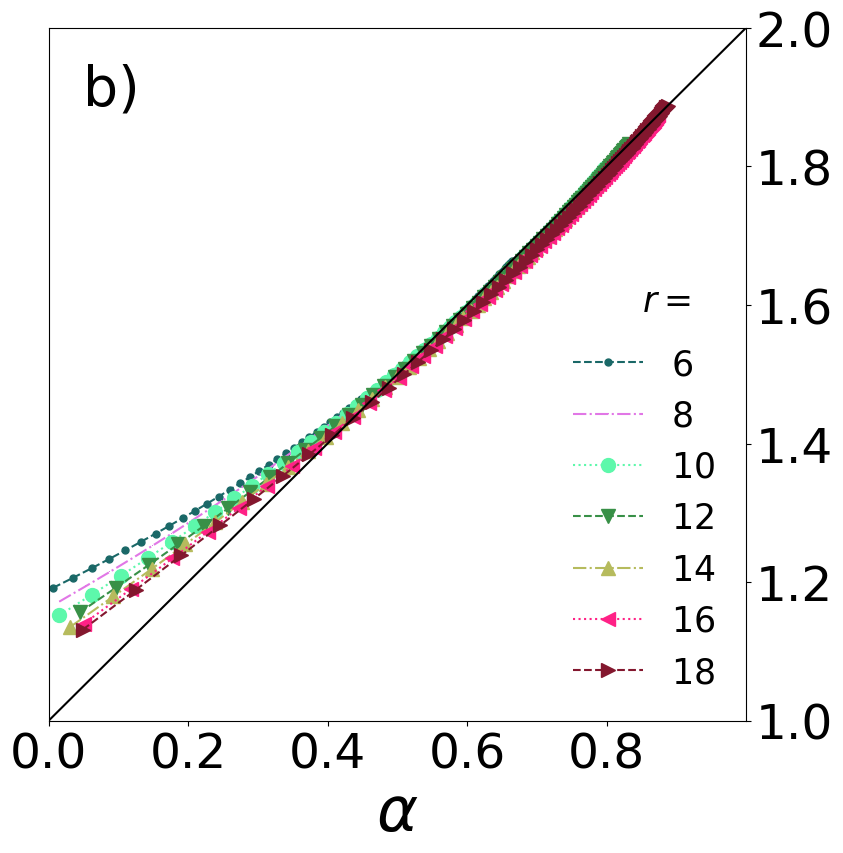

In [133]:
import random

fig, axs = plt.subplots(figsize=(9,9))
k_nk_vals = [(c_max,2) for c_max in range(4, 11)]

ps,quarantines = np.linspace(0.,0.99,100),True
xmin=None
xmax=None
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
cr = get_colors(len(k_nk_vals))
lins = ['dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted']+['dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted']+['dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted']

markers = ['.',',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
descriptions = ['point', 'pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left',
                'triangle_right', 'tri_down', 'tri_up', 'tri_left', 'tri_right', 'octagon',
                'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus',
                'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']
x=[]


_i = 0

rd_data = np.load('all.npy')    
for kval,nkval in k_nk_vals:
    alphas = rd_data[_i]
    axs.plot(alphas,((kval-1)*nkval-1)*ps*(1-np.array(alphas)) ,label=r"$"+str((kval-1)*nkval)+"$", color = cr[_i],linestyle=lins[_i], marker = markers[_i], ms = 10)
    _i += 1

if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
axs.set_xlim([0, 1])
axs.set_ylim([1, 2])
#axs.set_ylabel(r'$(r-1) p_e $' , fontsize = 45)
axs.set_xlabel(r'$\alpha$' , fontsize = 45)
axs.tick_params(axis='y', labelsize= 35)
axs.tick_params(axis='x', labelsize= 35)
axs.legend(loc = 4, fontsize = 25, frameon=False)
axs.plot(np.linspace(0, 1, 100), 1+np.linspace(0, 1, 100), color = 'black', linestyle = 'solid', ms = 40)
axs.text(0.05, 0.95, 'b)', transform=axs.transAxes, fontsize=40,va='top')
axs.yaxis.tick_right()
plt.xticks([0, 0.2, .4, .6, .8])
axs.text(0.85, 0.63, r'$r =$', transform=axs.transAxes, fontsize=25,va='top')


plt.savefig('7b.pdf',bbox_inches='tight')

# $\textbf{M}$ Matrix for 3-clique in the Complex Contagion Approximation

In [8]:
g=motif_graph(3,quarantines=True,persistent=False,singleinftrial=False)
print_motifs(g)
print()
M=get_M_matrix(g,verbose=True)
print()

#for critical solving alpha/p given p/alpha:
d=sympy.det(M - sympy.eye(len(g)))
print(sympy.latex(sympy.simplify(d)))

$i$ & $S$ & $I$ & $R$ \\
\hline
$ 1 $&$ 2 $&$ 1 $&$ 0 $\\
$ 2 $&$ 1 $&$ 1 $&$ 1 $\\
$ 3 $&$ 0 $&$ 2 $&$ 1 $\\
$ 4 $&$ 0 $&$ 1 $&$ 2 $\\

$(i,j)$ & $m_{ij}$ \\
$( 1 , 1 )$&$ - 2 p \left(\alpha - 1\right) \left(n_{c} - 1\right) $\\
$( 1 , 2 )$&$ p \left(\alpha - 1\right)^{2} \left(n_{c} - 1\right) $\\
$( 2 , 1 )$&$ 2 p \left(\alpha - 1\right) \left(- p \left(\alpha - 1\right) - 1\right) $\\
$( 3 , 1 )$&$ p^{2} \left(\alpha - 1\right)^{2} $\\
$( 4 , 2 )$&$ p \left(\alpha - 1\right)^{2} $\\

2 \alpha^{4} n_{c} p^{3} - 2 \alpha^{4} p^{3} - 8 \alpha^{3} n_{c} p^{3} + 2 \alpha^{3} n_{c} p^{2} + 8 \alpha^{3} p^{3} - 2 \alpha^{3} p^{2} + 12 \alpha^{2} n_{c} p^{3} - 6 \alpha^{2} n_{c} p^{2} - 12 \alpha^{2} p^{3} + 6 \alpha^{2} p^{2} - 8 \alpha n_{c} p^{3} + 6 \alpha n_{c} p^{2} + 2 \alpha n_{c} p + 8 \alpha p^{3} - 6 \alpha p^{2} - 2 \alpha p + 2 n_{c} p^{3} - 2 n_{c} p^{2} - 2 n_{c} p - 2 p^{3} + 2 p^{2} + 2 p + 1


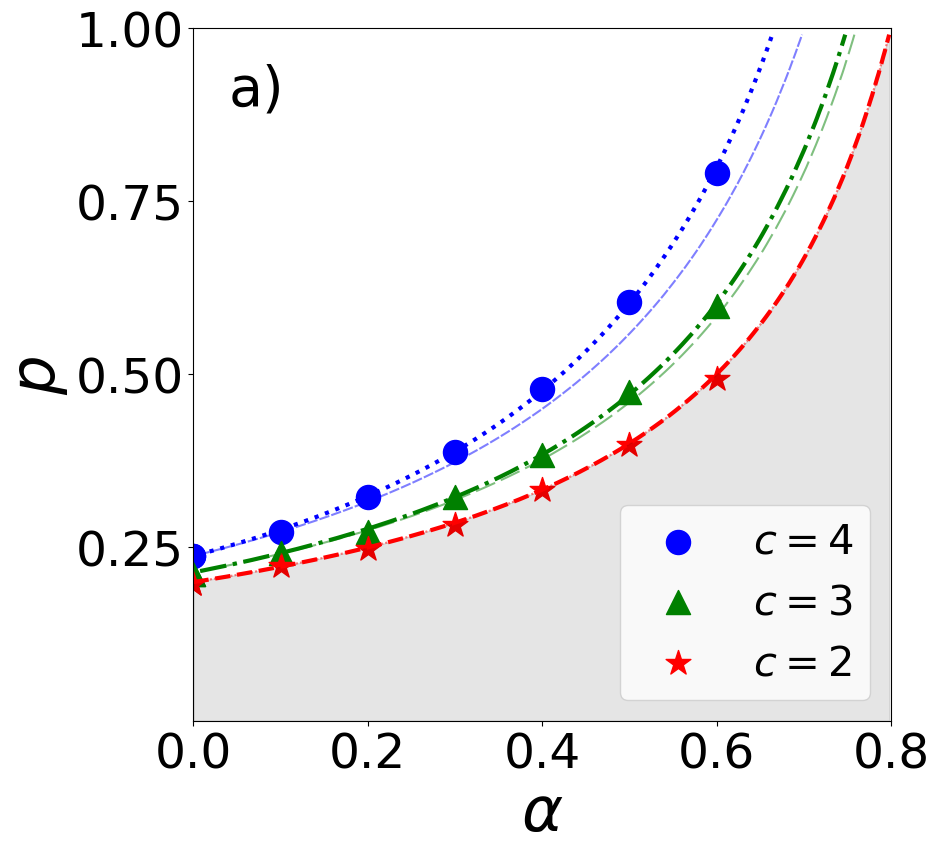

In [69]:
ALPHAS = np.load('ALPHAS.npy')
PA = np.load('PA.npy')
k_nk_vals,ps,quarantines = [(2,6),(3,3),(4,2)],np.linspace(0.2,0.99,100),True

fig, axs = plt.subplots(figsize=(9,9))
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
lins2 = [(0, (1, 1)), (5, (10, 3)), (0, (5, 1))]
_i = 0
for kval,nkval in k_nk_vals[::-1]:
    alphas2 = approx_data[_i]
    alphas = approx_data2[_i]
    axs.plot(alphas,ps , color = cr[_i],linestyle=lins2[_i], alpha=.5)
    axs.plot(alphas2, ps ,color = cr[_i], ms = 8, linestyle=lins[_i], linewidth=3)
    _i += 1


for _j in range(len(PA)):
    #axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
    axs.scatter(ALPHAS[_j][2],PA[_j][2],  marker = 'o', s = 300, color = cr[2])
    axs.scatter(ALPHAS[_j][1],PA[_j][1],  marker = '^', s = 300, color = cr[1])
    axs.scatter(ALPHAS[_j][0],PA[_j][0],  marker = '*', s = 350, color =cr[0])
    
    if  _j == 0:
        #axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
        axs.scatter(ALPHAS[_j][2],PA[_j][2],  marker = 'o', s = 300, color = cr[2], label=r"$c="+str(4)+"$")
        axs.scatter(ALPHAS[_j][1],PA[_j][1],  marker = '^', s = 300, color = cr[1], label=r"$c="+str(3)+"$" )
        axs.scatter(ALPHAS[_j][0],PA[_j][0],  marker = '*', s = 350, color =cr[0], label=r"$c="+str(2)+"$")


axs.set_xlim([0.0, .8])
axs.set_xlabel(r'$\alpha$' , fontsize = 45)
axs.tick_params(axis='y', labelsize= 35)
axs.tick_params(axis='x', labelsize= 35)
axs.set_yticks([.25, .5, .75, 1])
#axs.yaxis.set_label_position("right")
axs.set_ylabel(r'$p$' , fontsize = 45)
axs.legend(loc = 4,  fontsize= 30)    
axs.set_xlim([0.0, .8])
axs.set_ylim([0.0, 1])

axs.text(0.05, 0.95, 'a)', transform=axs.transAxes, fontsize=40,va='top')
axs.fill_between(approx_data[0], ps, 0, color='black', alpha=.1)

plt.savefig('10a.pdf',bbox_inches='tight')

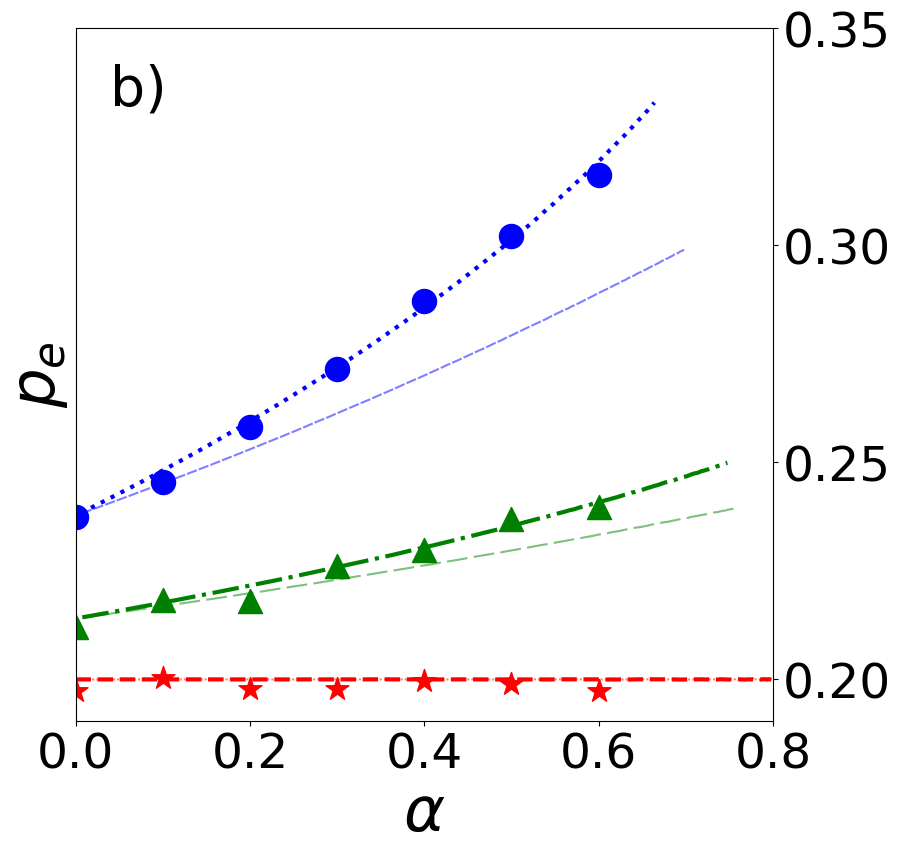

In [10]:
fig, axs = plt.subplots(figsize=(9,9))

cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
lins2 = [(0, (1, 1)), (5, (10, 3)), (0, (5, 1))]

_i = 0

for kval,nkval in k_nk_vals:
    alphas2 = approx_data[_i]
    alphas = approx_data2[_i]
    axs.plot(alphas,ps*(1-np.array(alphas)), color = cr[_i],linestyle=lins2[_i], alpha=.5)
    axs.plot(alphas2, ps*(1-np.array(alphas2)) ,color = cr[_i], linestyle=lins[_i], linewidth=3)

    _i += 1
if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]

for _j in range(len(PA)):
    #axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
    if _j != 0:
        axs.scatter(ALPHAS[_j][0],PA[_j][0]*(1-ALPHAS[_j][0]),  marker = '*', s = 300, color =cr[0])
        axs.scatter(ALPHAS[_j][1],PA[_j][1]*(1-ALPHAS[_j][1]),  marker = '^', s = 300, color = cr[1])
        axs.scatter(ALPHAS[_j][2],PA[_j][2]*(1-ALPHAS[_j][2]),  marker = 'o', s = 300, color = cr[2])
    else:
        axs.scatter(ALPHAS[_j][2],PA[_j][2]*(1-ALPHAS[_j][2]),  marker = 'o', s = 300, color = cr[2], label=r"$c="+str(4)+"$", )
        axs.scatter(ALPHAS[_j][1],PA[_j][1]*(1-ALPHAS[_j][1]),  marker = '^', s = 300, color = cr[1], label=r"$c="+str(3)+"$", )
        axs.scatter(ALPHAS[_j][0],PA[_j][0]*(1-ALPHAS[_j][0]),  marker = '*', s = 300, color =cr[0], label=r"$c="+str(2)+"$", )

        

#axs.set_ylabel(r'$p_{\mathrm{e}}$' , fontsize = 40)
axs.set_xlabel(r'$\alpha$' , fontsize = 45)
axs.tick_params(axis='y', labelsize= 35)
axs.tick_params(axis='x', labelsize= 35)
axs.set_yticks([.2, .25, .3, .35])
#axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_ylabel(r'$p_e$' , fontsize = 45)


    
axs.set_xlim([0.0, .8])
axs.text(0.05, 0.95, 'b)', transform=axs.transAxes, fontsize=40,va='top')

plt.savefig('10b.pdf',bbox_inches='tight')